In [1]:
import torch
from torchvision import transforms
from torch.autograd import Variable
from dataset import DatasetFromFolder,DatasetFromFolderTest
from model import Generator, Discriminator
#import utils
import argparse
import os
from logger import Logger
import matplotlib.pyplot as plt
from PIL import Image , ImageOps
import numpy as np
#import imageio
from matplotlib.transforms import Bbox
import pylab

In [2]:
# For logger
def to_np(x):
    return x.data.cpu().numpy()

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)


# De-normalization
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)


# Plot losses
def plot_loss(d_losses, g_losses, num_epochs, save=False, ex_dir='results/', show=False):
    fig, ax = plt.subplots()
    ax.set_xlim(0, num_epochs)
    ax.set_ylim(0, max(np.max(g_losses), np.max(d_losses))*1.1)
    plt.xlabel('# of Epochs')
    plt.ylabel('Loss values')
    plt.plot(d_losses, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.legend()

    # save figure
    if save:
        if not os.path.exists(ex_dir):
            os.makedirs(ex_dir)
        save_fn = ex_dir + 'Loss_values_epoch_{:d}'.format(num_epochs) + '.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()


def plot_test_result(input, target, gen_image, epoch, 
                     training=True, save=False, ex_dir='results/', show=False, fig_size=(10, 10)):
    if not training:
        fig_size = (input.size(2) * 6 / 100, input.size(3)*2/100)

    fig, axes = plt.subplots(1, 3, figsize=fig_size)
    imgs = [input, gen_image, target]
    for ax, img in zip(axes.flatten(), imgs):
        ax.axis('off')
        ax.set_adjustable('box-forced')
        # Scale to 0-255
        img = (((img[0] - img[0].min()) * 255) / (img[0].max() - img[0].min())).numpy().transpose(1, 2, 0).astype(np.uint8)
        ax.imshow(img, cmap=None, aspect='equal')
        
#     for ax, color in zip(axes.flatten(), ['green', 'green', 'green']):
#         plt.setp(ax.spines.values(), color=color)
#         plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=color)
    
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    if training:
        title = 'Epoch {0}'.format(epoch + 1)
        fig.text(0.5, 0.04, title, ha='center')

    # save figure
    if save:
        if not os.path.exists(ex_dir):
            os.makedirs(ex_dir)
        
        
        if training:
            save_fn = ex_dir + 'Result_epoch_{:d}'.format(epoch+1) + '.png'
        else:
            save_fn = ex_dir + 'Test_result_{:d}'.format(epoch+1) + '.png'
            fig.subplots_adjust(bottom=0)
            fig.subplots_adjust(top=1)
            fig.subplots_adjust(right=1)
            fig.subplots_adjust(left=0)
        plt.savefig(save_fn)
        
    if show:
        plt.show()
    else:
        plt.close()

        



In [3]:

# parser = argparse.ArgumentParser()
# parser.add_argument('--dataset', required=False, default='facades', help='input dataset')
# parser.add_argument('--direction', required=False, default='BtoA', help='input and target image order')
# parser.add_argument('--batch_size', type=int, default=1, help='train batch size')
# parser.add_argument('--ngf', type=int, default=64)
# parser.add_argument('--ndf', type=int, default=64)
# parser.add_argument('--input_size', type=int, default=256, help='input size')
# parser.add_argument('--resize_scale', type=int, default=286, help='resize scale (0 is false)')
# parser.add_argument('--crop_size', type=int, default=256, help='crop size (0 is false)')
# parser.add_argument('--fliplr', type=bool, default=True, help='random fliplr True of False')
# parser.add_argument('--num_epochs', type=int, default=200, help='number of train epochs')
# parser.add_argument('--lrG', type=float, default=0.0002, help='learning rate for generator, default=0.0002')
# parser.add_argument('--lrD', type=float, default=0.0002, help='learning rate for discriminator, default=0.0002')
# parser.add_argument('--lamb', type=float, default=100, help='lambda for L1 loss')
# parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for Adam optimizer')
# parser.add_argument('--beta2', type=float, default=0.999, help='beta2 for Adam optimizer')
# params = parser.parse_args()
# print(params)

In [4]:
dataset="seg"
direction="BtoA"
batch_size=4
ngf= 64
ndf= 64
input_size =256
resize_scale=2000
crop_size =100


fliplr=False
num_epochs=12
lrG=0.002 #0.0002
lrD=0.002
lamb=100
beta1=0.5
beta2=0.999

In [5]:

# #data= pd.read_csv('C://Personal//MediaEvalCompitition//Kvasir//images//CLEAN_House%s.csv'%(house_nr)).values
# f_path="segdata//train//"
# image_path="segdata//train//images//"
# mask_path= "segdata//train//masks//"
# image_name=("cju0roawvklrq0799vmjorwfv.jpg")
# sample_im = Image.open(image_path+image_name) 
# sample_msk =  Image.open(mask_path+image_name) 

In [6]:

if not os.path.exists('id_log.txt'):
    with open('id_log.txt','w') as f:
        f.write('0')
with open('id_log.txt','r') as f:
    run_id = int(f.read())
    run_id+=1 
with open('id_log.txt','w') as f:
    f.write(str(run_id))
    
    
# Directories for loading data and saving results
data_dir = 'Kvasir-SEG//' # 'segdata_reshaped_all//' 
save_dir = dataset + '_results/'
model_dir = dataset + '_model/'
ex_dir=save_dir+str(run_id)+"/"


if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    


if not os.path.exists(ex_dir):
    os.makedirs(ex_dir)
    
if not os.path.exists(model_dir):
    os.mkdir(model_dir)


In [7]:
#plt.figure()
#plt.imshow(sample_im) 
#plt.figure()
#plt.imshow(sample_msk) 

import torch.utils.data as data

class DataLoaderSegmentation(data.Dataset):
    def __init__(self, folder_path):
        super(DataLoaderSegmentation, self).__init__()
        self.img_files = glob.glob(os.path.join(folder_path,'images','*.jpg'))
        self.mask_files = []
        for img_path in self.img_files:
             self.mask_files.append(os.path.join(folder_path,'masks',os.path.basename(img_path))) 

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = Image.open(img_path)
            im = np.array(data)
            label =Image.open(mask_path)
            msk=np.array(label)
            im_return=torch.from_numpy(im)#.float()
            msk_return=torch.from_numpy(msk)#.float()
#            plt.figure()
#            plt.imshow(im)
#            plt.show()
            return im_return, msk_return
    def __len__(self):
        return len(self.img_files)


In [8]:
data_dir

'Kvasir-SEG//'

In [9]:
# Data pre-processing
transform = transforms.Compose([transforms.Resize(input_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

train_data = DatasetFromFolder(data_dir, subfolder='train/', transform=transform,
                               resize_scale=resize_scale, crop_size=crop_size, fliplr=fliplr)


train_data_loader = torch.utils.data.DataLoader(dataset=train_data,
                                                batch_size=batch_size,
                                                shuffle=True)

 
test_data_loader = torch.utils.data.DataLoader(dataset=train_data,
                                                batch_size=1,
                                                shuffle=False)
test_input, test_target = test_data_loader.__iter__().__next__()


In [10]:
# im_s=test_input[0,:,:,:].permute(1,2,0)
# msk_s=test_target[0,:,:,:].permute(1,2,0)
# #fig, (ax1, ax2) = plt.subplots(1, 2)
# plt.figure()
# plt.imshow(im_s)
# plt.show()
# plt.figure()
# plt.imshow(msk_s)
# plt.show()
# print(ind)



In [11]:
G = Generator(3, ngf, 3)
D = Discriminator(6, ndf, 1)

G.normal_weight_init(mean=0.0, std=0.02)
D.normal_weight_init(mean=0.0, std=0.02)

D_log_dir = ex_dir + 'D_logs'
G_log_dir = ex_dir + 'G_logs'
if not os.path.exists(D_log_dir):
    os.mkdir(D_log_dir)

# Set the logger

D_logger = Logger(D_log_dir)


if not os.path.exists(G_log_dir):
    os.mkdir(G_log_dir)
G_logger = Logger(G_log_dir)

# Loss function
BCE_loss = torch.nn.BCELoss().cuda()
L1_loss = torch.nn.L1Loss().cuda()

G.cuda()
D.cuda()


/home/aahmed/1Medico/model.py:103: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(m.conv.weight, mean, std)
/home/aahmed/1Medico/model.py:105: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(m.deconv.weight, mean, std)
/home/aahmed/1Medico/model.py:186: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(m.conv.weight, mean, std)


Discriminator(
  (conv1): ConvBlock(
    (conv): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (lrelu): LeakyReLU(negative_slope=0.2, inplace)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): ConvBlock(
    (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (lrelu): LeakyReLU(negative_slope=0.2, inplace)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): ConvBlock(
    (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (lrelu): LeakyReLU(negative_slope=0.2, inplace)
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): ConvBlock(
    (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (lrelu): LeakyReLU(negative_slope=0.2, inplace)
    (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [12]:
6*64

384

In [13]:

# Optimizers
G_optimizer = torch.optim.Adam(G.parameters(), lr=lrG, betas=(beta1, beta2))
D_optimizer = torch.optim.Adam(D.parameters(), lr=lrD, betas=(beta1, beta2))

# Training

In [14]:

# Training GAN
D_avg_losses = []
G_avg_losses = []

step = 0
for epoch in range(num_epochs):
    D_losses = []
    G_losses = []

    # training
    for i, (input, target) in enumerate(train_data_loader):

        # input & target image data
        x_ = Variable(input.cuda())
        y_ = Variable(target.cuda())

        # Train discriminator with real data
        D_real_decision = D(x_, y_).squeeze()
        real_ = Variable(torch.ones(D_real_decision.size()).cuda())
        D_real_loss = BCE_loss(D_real_decision, real_)


        # Train discriminator with fake data
        gen_image = G(x_)
        D_fake_decision = D(x_, gen_image).squeeze()
        fake_ = Variable(torch.zeros(D_fake_decision.size()).cuda())
        D_fake_loss = BCE_loss(D_fake_decision, fake_)

        # Back propagation
        D_loss = (D_real_loss + D_fake_loss) * 0.5
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Train generator
        gen_image = G(x_)
        D_fake_decision = D(x_, gen_image).squeeze()
        G_fake_loss = BCE_loss(D_fake_decision, real_)

        # L1 loss
        l1_loss = lamb * L1_loss(gen_image, y_)

        # Back propagation
        G_loss = G_fake_loss + l1_loss
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # loss values
        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

        print('Epoch [%d/%d], Step [%d/%d], D_loss: %.4f, G_loss: %.4f'
              % (epoch+1, num_epochs, i+1, len(train_data_loader), D_loss.item(), G_loss.item()))

        # ============ TensorBoard logging ============#
        D_logger.scalar_summary('losses', D_loss.item(), step + 1)
        G_logger.scalar_summary('losses', G_loss.item(), step + 1)
        step += 1

    D_avg_loss = torch.mean(torch.FloatTensor(D_losses))
    G_avg_loss = torch.mean(torch.FloatTensor(G_losses))

    # avg loss values for plot
    D_avg_losses.append(D_avg_loss)
    G_avg_losses.append(G_avg_loss)

    # Show result for test image
    
    test_input, test_target = test_data_loader.__iter__().__next__()

    gen_image = G(Variable(test_input.cuda()))
    gen_image = gen_image.cpu().data
    plot_test_result(test_input, test_target, gen_image, epoch, save=True, ex_dir=ex_dir)
    
    save_model_fn=ex_dir+"Seg_GAN.pth"
        
    torch.save({"g_state_dict":G.state_dict(),
                "d_state_dict":D.state_dict(),
                "g_opt_dict":G_optimizer.state_dict(),
                "d_opt_dict":G_optimizer.state_dict(),
                       },
                       save_model_fn
                      )


Epoch [1/12], Step [1/250], D_loss: 0.7572, G_loss: 94.1560
Epoch [1/12], Step [2/250], D_loss: 1.5081, G_loss: 89.0122
Epoch [1/12], Step [3/250], D_loss: 3.0067, G_loss: 76.5892
Epoch [1/12], Step [4/250], D_loss: 1.6609, G_loss: 64.9747
Epoch [1/12], Step [5/250], D_loss: 0.9089, G_loss: 70.1975
Epoch [1/12], Step [6/250], D_loss: 0.8289, G_loss: 62.9978
Epoch [1/12], Step [7/250], D_loss: 0.7172, G_loss: 55.0161
Epoch [1/12], Step [8/250], D_loss: 0.6846, G_loss: 46.7107
Epoch [1/12], Step [9/250], D_loss: 0.6634, G_loss: 45.0377
Epoch [1/12], Step [10/250], D_loss: 0.6723, G_loss: 34.9888
Epoch [1/12], Step [11/250], D_loss: 0.6677, G_loss: 19.5176
Epoch [1/12], Step [12/250], D_loss: 0.6532, G_loss: 24.8902
Epoch [1/12], Step [13/250], D_loss: 0.6524, G_loss: 40.4717
Epoch [1/12], Step [14/250], D_loss: 0.6359, G_loss: 41.7031
Epoch [1/12], Step [15/250], D_loss: 0.6109, G_loss: 36.6988
Epoch [1/12], Step [16/250], D_loss: 0.5977, G_loss: 19.8449
Epoch [1/12], Step [17/250], D_lo

Epoch [1/12], Step [135/250], D_loss: 0.0090, G_loss: 40.1459
Epoch [1/12], Step [136/250], D_loss: 0.0094, G_loss: 26.5100
Epoch [1/12], Step [137/250], D_loss: 0.0095, G_loss: 23.9955
Epoch [1/12], Step [138/250], D_loss: 0.0119, G_loss: 17.0874
Epoch [1/12], Step [139/250], D_loss: 0.0115, G_loss: 82.4354
Epoch [1/12], Step [140/250], D_loss: 0.0108, G_loss: 28.3140
Epoch [1/12], Step [141/250], D_loss: 0.0102, G_loss: 24.8028
Epoch [1/12], Step [142/250], D_loss: 0.0077, G_loss: 46.7193
Epoch [1/12], Step [143/250], D_loss: 0.0079, G_loss: 32.9147
Epoch [1/12], Step [144/250], D_loss: 0.0096, G_loss: 20.0464
Epoch [1/12], Step [145/250], D_loss: 0.0077, G_loss: 28.2950
Epoch [1/12], Step [146/250], D_loss: 0.0085, G_loss: 19.9565
Epoch [1/12], Step [147/250], D_loss: 0.0089, G_loss: 19.3150
Epoch [1/12], Step [148/250], D_loss: 0.0079, G_loss: 21.5371
Epoch [1/12], Step [149/250], D_loss: 0.0068, G_loss: 40.9883
Epoch [1/12], Step [150/250], D_loss: 0.0069, G_loss: 49.8082
Epoch [1

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


Epoch [2/12], Step [1/250], D_loss: 0.0019, G_loss: 31.0283
Epoch [2/12], Step [2/250], D_loss: 0.0025, G_loss: 20.3192
Epoch [2/12], Step [3/250], D_loss: 0.0021, G_loss: 26.1669
Epoch [2/12], Step [4/250], D_loss: 0.0022, G_loss: 32.1395
Epoch [2/12], Step [5/250], D_loss: 0.0020, G_loss: 47.8305
Epoch [2/12], Step [6/250], D_loss: 0.0020, G_loss: 52.6770
Epoch [2/12], Step [7/250], D_loss: 0.0019, G_loss: 55.2776
Epoch [2/12], Step [8/250], D_loss: 0.0023, G_loss: 23.2202
Epoch [2/12], Step [9/250], D_loss: 0.0019, G_loss: 36.6899
Epoch [2/12], Step [10/250], D_loss: 0.0018, G_loss: 33.8457
Epoch [2/12], Step [11/250], D_loss: 0.0019, G_loss: 26.1476
Epoch [2/12], Step [12/250], D_loss: 0.0018, G_loss: 33.3013
Epoch [2/12], Step [13/250], D_loss: 0.0017, G_loss: 48.8184
Epoch [2/12], Step [14/250], D_loss: 0.0019, G_loss: 26.7912
Epoch [2/12], Step [15/250], D_loss: 0.0031, G_loss: 14.7463
Epoch [2/12], Step [16/250], D_loss: 0.0019, G_loss: 24.6520
Epoch [2/12], Step [17/250], D_lo

Epoch [2/12], Step [135/250], D_loss: 0.3875, G_loss: 15.9258
Epoch [2/12], Step [136/250], D_loss: 0.5865, G_loss: 27.2572
Epoch [2/12], Step [137/250], D_loss: 0.0566, G_loss: 29.9347
Epoch [2/12], Step [138/250], D_loss: 0.0824, G_loss: 33.8788
Epoch [2/12], Step [139/250], D_loss: 0.0264, G_loss: 38.2027
Epoch [2/12], Step [140/250], D_loss: 1.0243, G_loss: 10.6023
Epoch [2/12], Step [141/250], D_loss: 1.4345, G_loss: 24.0125
Epoch [2/12], Step [142/250], D_loss: 0.4380, G_loss: 21.0179
Epoch [2/12], Step [143/250], D_loss: 0.1090, G_loss: 29.1746
Epoch [2/12], Step [144/250], D_loss: 0.0622, G_loss: 56.6449
Epoch [2/12], Step [145/250], D_loss: 0.4438, G_loss: 18.9407
Epoch [2/12], Step [146/250], D_loss: 0.0789, G_loss: 30.3439
Epoch [2/12], Step [147/250], D_loss: 0.0273, G_loss: 31.9078
Epoch [2/12], Step [148/250], D_loss: 0.1764, G_loss: 37.5819
Epoch [2/12], Step [149/250], D_loss: 0.2138, G_loss: 20.5692
Epoch [2/12], Step [150/250], D_loss: 0.2886, G_loss: 27.7914
Epoch [2

Epoch [3/12], Step [18/250], D_loss: 0.3256, G_loss: 26.3656
Epoch [3/12], Step [19/250], D_loss: 0.8775, G_loss: 20.5841
Epoch [3/12], Step [20/250], D_loss: 0.5307, G_loss: 31.5314
Epoch [3/12], Step [21/250], D_loss: 0.0789, G_loss: 37.4391
Epoch [3/12], Step [22/250], D_loss: 0.1498, G_loss: 42.5183
Epoch [3/12], Step [23/250], D_loss: 0.0710, G_loss: 31.7017
Epoch [3/12], Step [24/250], D_loss: 0.0519, G_loss: 47.9494
Epoch [3/12], Step [25/250], D_loss: 0.2976, G_loss: 25.2597
Epoch [3/12], Step [26/250], D_loss: 0.1075, G_loss: 19.9127
Epoch [3/12], Step [27/250], D_loss: 0.2217, G_loss: 24.5983
Epoch [3/12], Step [28/250], D_loss: 0.0520, G_loss: 43.1696
Epoch [3/12], Step [29/250], D_loss: 0.2549, G_loss: 25.3706
Epoch [3/12], Step [30/250], D_loss: 0.1075, G_loss: 27.2006
Epoch [3/12], Step [31/250], D_loss: 0.1452, G_loss: 42.4092
Epoch [3/12], Step [32/250], D_loss: 0.7289, G_loss: 20.2977
Epoch [3/12], Step [33/250], D_loss: 1.5956, G_loss: 49.1471
Epoch [3/12], Step [34/2

Epoch [3/12], Step [152/250], D_loss: 0.5341, G_loss: 29.3774
Epoch [3/12], Step [153/250], D_loss: 0.1692, G_loss: 33.3198
Epoch [3/12], Step [154/250], D_loss: 0.6571, G_loss: 14.4281
Epoch [3/12], Step [155/250], D_loss: 0.1460, G_loss: 21.7652
Epoch [3/12], Step [156/250], D_loss: 1.4322, G_loss: 22.9056
Epoch [3/12], Step [157/250], D_loss: 0.3487, G_loss: 30.5784
Epoch [3/12], Step [158/250], D_loss: 0.1154, G_loss: 55.5378
Epoch [3/12], Step [159/250], D_loss: 0.2256, G_loss: 40.6854
Epoch [3/12], Step [160/250], D_loss: 1.5481, G_loss: 28.8134
Epoch [3/12], Step [161/250], D_loss: 0.3016, G_loss: 21.2373
Epoch [3/12], Step [162/250], D_loss: 0.4020, G_loss: 28.6205
Epoch [3/12], Step [163/250], D_loss: 0.0736, G_loss: 55.2274
Epoch [3/12], Step [164/250], D_loss: 0.9816, G_loss: 18.0429
Epoch [3/12], Step [165/250], D_loss: 0.2439, G_loss: 20.6703
Epoch [3/12], Step [166/250], D_loss: 0.2846, G_loss: 36.2383
Epoch [3/12], Step [167/250], D_loss: 0.6119, G_loss: 19.6912
Epoch [3

Epoch [4/12], Step [35/250], D_loss: 0.1115, G_loss: 38.9030
Epoch [4/12], Step [36/250], D_loss: 0.2182, G_loss: 31.2840
Epoch [4/12], Step [37/250], D_loss: 0.0414, G_loss: 40.0620
Epoch [4/12], Step [38/250], D_loss: 0.0553, G_loss: 44.2491
Epoch [4/12], Step [39/250], D_loss: 0.7590, G_loss: 20.7042
Epoch [4/12], Step [40/250], D_loss: 0.6379, G_loss: 16.7098
Epoch [4/12], Step [41/250], D_loss: 0.4893, G_loss: 21.5190
Epoch [4/12], Step [42/250], D_loss: 0.0672, G_loss: 35.9297
Epoch [4/12], Step [43/250], D_loss: 0.1337, G_loss: 38.1030
Epoch [4/12], Step [44/250], D_loss: 0.2513, G_loss: 21.5410
Epoch [4/12], Step [45/250], D_loss: 0.1290, G_loss: 33.9865
Epoch [4/12], Step [46/250], D_loss: 0.2290, G_loss: 36.4547
Epoch [4/12], Step [47/250], D_loss: 0.1812, G_loss: 22.9653
Epoch [4/12], Step [48/250], D_loss: 1.4210, G_loss: 25.0754
Epoch [4/12], Step [49/250], D_loss: 0.2983, G_loss: 18.3222
Epoch [4/12], Step [50/250], D_loss: 0.7520, G_loss: 16.9341
Epoch [4/12], Step [51/2

Epoch [4/12], Step [169/250], D_loss: 0.0702, G_loss: 41.9675
Epoch [4/12], Step [170/250], D_loss: 0.0660, G_loss: 31.0616
Epoch [4/12], Step [171/250], D_loss: 0.1597, G_loss: 30.2823
Epoch [4/12], Step [172/250], D_loss: 0.7360, G_loss: 13.8208
Epoch [4/12], Step [173/250], D_loss: 0.9301, G_loss: 24.2409
Epoch [4/12], Step [174/250], D_loss: 0.4454, G_loss: 35.3544
Epoch [4/12], Step [175/250], D_loss: 1.6986, G_loss: 18.8191
Epoch [4/12], Step [176/250], D_loss: 0.2243, G_loss: 28.4503
Epoch [4/12], Step [177/250], D_loss: 0.3873, G_loss: 15.2382
Epoch [4/12], Step [178/250], D_loss: 0.2237, G_loss: 31.7508
Epoch [4/12], Step [179/250], D_loss: 1.2071, G_loss: 19.1874
Epoch [4/12], Step [180/250], D_loss: 0.4042, G_loss: 33.8562
Epoch [4/12], Step [181/250], D_loss: 0.2748, G_loss: 28.1698
Epoch [4/12], Step [182/250], D_loss: 0.5875, G_loss: 13.0065
Epoch [4/12], Step [183/250], D_loss: 0.2068, G_loss: 24.8677
Epoch [4/12], Step [184/250], D_loss: 0.2806, G_loss: 58.1840
Epoch [4

Epoch [5/12], Step [53/250], D_loss: 0.1732, G_loss: 34.5506
Epoch [5/12], Step [54/250], D_loss: 0.7392, G_loss: 29.3024
Epoch [5/12], Step [55/250], D_loss: 1.0815, G_loss: 17.7504
Epoch [5/12], Step [56/250], D_loss: 1.0134, G_loss: 21.9690
Epoch [5/12], Step [57/250], D_loss: 0.3930, G_loss: 20.2454
Epoch [5/12], Step [58/250], D_loss: 0.0951, G_loss: 33.2397
Epoch [5/12], Step [59/250], D_loss: 0.0847, G_loss: 26.0591
Epoch [5/12], Step [60/250], D_loss: 1.0287, G_loss: 15.0427
Epoch [5/12], Step [61/250], D_loss: 0.0624, G_loss: 25.8002
Epoch [5/12], Step [62/250], D_loss: 0.6308, G_loss: 18.9642
Epoch [5/12], Step [63/250], D_loss: 0.5028, G_loss: 12.3749
Epoch [5/12], Step [64/250], D_loss: 0.0612, G_loss: 59.0904
Epoch [5/12], Step [65/250], D_loss: 0.4788, G_loss: 22.9484
Epoch [5/12], Step [66/250], D_loss: 0.4447, G_loss: 31.8745
Epoch [5/12], Step [67/250], D_loss: 0.5217, G_loss: 29.5071
Epoch [5/12], Step [68/250], D_loss: 0.0411, G_loss: 45.1716
Epoch [5/12], Step [69/2

Epoch [5/12], Step [186/250], D_loss: 0.1643, G_loss: 34.6702
Epoch [5/12], Step [187/250], D_loss: 0.0386, G_loss: 31.3630
Epoch [5/12], Step [188/250], D_loss: 0.1525, G_loss: 35.4614
Epoch [5/12], Step [189/250], D_loss: 0.1673, G_loss: 67.0466
Epoch [5/12], Step [190/250], D_loss: 0.5424, G_loss: 19.5299
Epoch [5/12], Step [191/250], D_loss: 0.7089, G_loss: 12.7273
Epoch [5/12], Step [192/250], D_loss: 0.9579, G_loss: 21.6082
Epoch [5/12], Step [193/250], D_loss: 0.8120, G_loss: 53.2587
Epoch [5/12], Step [194/250], D_loss: 2.0125, G_loss: 17.7257
Epoch [5/12], Step [195/250], D_loss: 0.9104, G_loss: 33.5892
Epoch [5/12], Step [196/250], D_loss: 0.9938, G_loss: 21.3590
Epoch [5/12], Step [197/250], D_loss: 0.6581, G_loss: 24.0684
Epoch [5/12], Step [198/250], D_loss: 0.5018, G_loss: 23.3630
Epoch [5/12], Step [199/250], D_loss: 0.2807, G_loss: 28.2946
Epoch [5/12], Step [200/250], D_loss: 0.7928, G_loss: 21.3944
Epoch [5/12], Step [201/250], D_loss: 0.3055, G_loss: 26.0409
Epoch [5

Epoch [6/12], Step [70/250], D_loss: 0.1566, G_loss: 29.0514
Epoch [6/12], Step [71/250], D_loss: 0.2321, G_loss: 40.4516
Epoch [6/12], Step [72/250], D_loss: 0.0800, G_loss: 39.1652
Epoch [6/12], Step [73/250], D_loss: 1.5797, G_loss: 18.3544
Epoch [6/12], Step [74/250], D_loss: 0.2852, G_loss: 24.7408
Epoch [6/12], Step [75/250], D_loss: 0.9329, G_loss: 28.7303
Epoch [6/12], Step [76/250], D_loss: 0.2587, G_loss: 31.1587
Epoch [6/12], Step [77/250], D_loss: 0.6066, G_loss: 21.7265
Epoch [6/12], Step [78/250], D_loss: 0.5112, G_loss: 20.7840
Epoch [6/12], Step [79/250], D_loss: 0.2913, G_loss: 20.6755
Epoch [6/12], Step [80/250], D_loss: 0.9833, G_loss: 30.5573
Epoch [6/12], Step [81/250], D_loss: 0.3371, G_loss: 37.4111
Epoch [6/12], Step [82/250], D_loss: 0.5480, G_loss: 34.7390
Epoch [6/12], Step [83/250], D_loss: 0.1912, G_loss: 27.5302
Epoch [6/12], Step [84/250], D_loss: 0.2905, G_loss: 21.7442
Epoch [6/12], Step [85/250], D_loss: 0.1524, G_loss: 36.1232
Epoch [6/12], Step [86/2

Epoch [6/12], Step [203/250], D_loss: 0.1015, G_loss: 55.2967
Epoch [6/12], Step [204/250], D_loss: 0.1134, G_loss: 25.5712
Epoch [6/12], Step [205/250], D_loss: 0.0832, G_loss: 31.4094
Epoch [6/12], Step [206/250], D_loss: 0.8906, G_loss: 20.7328
Epoch [6/12], Step [207/250], D_loss: 0.3538, G_loss: 23.5385
Epoch [6/12], Step [208/250], D_loss: 0.4784, G_loss: 21.4857
Epoch [6/12], Step [209/250], D_loss: 0.9278, G_loss: 15.9874
Epoch [6/12], Step [210/250], D_loss: 0.7020, G_loss: 22.4256
Epoch [6/12], Step [211/250], D_loss: 0.2492, G_loss: 22.1974
Epoch [6/12], Step [212/250], D_loss: 0.3163, G_loss: 18.2173
Epoch [6/12], Step [213/250], D_loss: 0.5218, G_loss: 31.0714
Epoch [6/12], Step [214/250], D_loss: 0.1718, G_loss: 26.3562
Epoch [6/12], Step [215/250], D_loss: 0.2229, G_loss: 24.9807
Epoch [6/12], Step [216/250], D_loss: 0.3908, G_loss: 26.8269
Epoch [6/12], Step [217/250], D_loss: 0.4310, G_loss: 26.4824
Epoch [6/12], Step [218/250], D_loss: 0.4299, G_loss: 24.0707
Epoch [6

Epoch [7/12], Step [87/250], D_loss: 0.1412, G_loss: 28.9686
Epoch [7/12], Step [88/250], D_loss: 0.9480, G_loss: 16.8050
Epoch [7/12], Step [89/250], D_loss: 0.2517, G_loss: 15.4049
Epoch [7/12], Step [90/250], D_loss: 0.2109, G_loss: 18.2605
Epoch [7/12], Step [91/250], D_loss: 0.3796, G_loss: 47.2152
Epoch [7/12], Step [92/250], D_loss: 0.1468, G_loss: 35.7365
Epoch [7/12], Step [93/250], D_loss: 0.1013, G_loss: 52.6439
Epoch [7/12], Step [94/250], D_loss: 0.4184, G_loss: 16.1656
Epoch [7/12], Step [95/250], D_loss: 0.9993, G_loss: 9.8045
Epoch [7/12], Step [96/250], D_loss: 0.5515, G_loss: 15.0030
Epoch [7/12], Step [97/250], D_loss: 0.4346, G_loss: 33.0527
Epoch [7/12], Step [98/250], D_loss: 0.4425, G_loss: 28.1113
Epoch [7/12], Step [99/250], D_loss: 0.6613, G_loss: 33.0222
Epoch [7/12], Step [100/250], D_loss: 0.7457, G_loss: 25.1647
Epoch [7/12], Step [101/250], D_loss: 0.4736, G_loss: 24.2086
Epoch [7/12], Step [102/250], D_loss: 0.2396, G_loss: 24.4298
Epoch [7/12], Step [10

Epoch [7/12], Step [220/250], D_loss: 0.2601, G_loss: 50.9230
Epoch [7/12], Step [221/250], D_loss: 0.8946, G_loss: 25.0655
Epoch [7/12], Step [222/250], D_loss: 0.5773, G_loss: 15.8759
Epoch [7/12], Step [223/250], D_loss: 0.3034, G_loss: 18.6098
Epoch [7/12], Step [224/250], D_loss: 0.4574, G_loss: 12.3764
Epoch [7/12], Step [225/250], D_loss: 0.4213, G_loss: 19.0330
Epoch [7/12], Step [226/250], D_loss: 0.2970, G_loss: 22.7482
Epoch [7/12], Step [227/250], D_loss: 0.5442, G_loss: 25.3589
Epoch [7/12], Step [228/250], D_loss: 0.3172, G_loss: 30.3824
Epoch [7/12], Step [229/250], D_loss: 0.4546, G_loss: 22.6045
Epoch [7/12], Step [230/250], D_loss: 0.4199, G_loss: 11.8787
Epoch [7/12], Step [231/250], D_loss: 0.2286, G_loss: 39.1136
Epoch [7/12], Step [232/250], D_loss: 0.5484, G_loss: 25.6484
Epoch [7/12], Step [233/250], D_loss: 0.1606, G_loss: 40.6004
Epoch [7/12], Step [234/250], D_loss: 0.7041, G_loss: 21.0067
Epoch [7/12], Step [235/250], D_loss: 0.9110, G_loss: 9.8826
Epoch [7/

Epoch [8/12], Step [104/250], D_loss: 0.1845, G_loss: 39.5152
Epoch [8/12], Step [105/250], D_loss: 0.2606, G_loss: 18.7024
Epoch [8/12], Step [106/250], D_loss: 1.1563, G_loss: 31.6731
Epoch [8/12], Step [107/250], D_loss: 0.4715, G_loss: 17.0470
Epoch [8/12], Step [108/250], D_loss: 0.9568, G_loss: 15.6034
Epoch [8/12], Step [109/250], D_loss: 0.4975, G_loss: 29.2356
Epoch [8/12], Step [110/250], D_loss: 0.3914, G_loss: 22.2583
Epoch [8/12], Step [111/250], D_loss: 0.5671, G_loss: 19.8338
Epoch [8/12], Step [112/250], D_loss: 0.5963, G_loss: 15.1132
Epoch [8/12], Step [113/250], D_loss: 0.3297, G_loss: 31.1927
Epoch [8/12], Step [114/250], D_loss: 0.3423, G_loss: 31.8726
Epoch [8/12], Step [115/250], D_loss: 0.1658, G_loss: 46.6597
Epoch [8/12], Step [116/250], D_loss: 0.4178, G_loss: 23.9389
Epoch [8/12], Step [117/250], D_loss: 0.0822, G_loss: 34.2255
Epoch [8/12], Step [118/250], D_loss: 0.5658, G_loss: 17.7206
Epoch [8/12], Step [119/250], D_loss: 0.8807, G_loss: 17.8591
Epoch [8

Epoch [8/12], Step [237/250], D_loss: 0.5207, G_loss: 22.6515
Epoch [8/12], Step [238/250], D_loss: 0.8818, G_loss: 15.3229
Epoch [8/12], Step [239/250], D_loss: 0.1583, G_loss: 35.3537
Epoch [8/12], Step [240/250], D_loss: 0.1887, G_loss: 31.1373
Epoch [8/12], Step [241/250], D_loss: 0.1328, G_loss: 23.4526
Epoch [8/12], Step [242/250], D_loss: 0.1927, G_loss: 22.3885
Epoch [8/12], Step [243/250], D_loss: 0.2899, G_loss: 17.3153
Epoch [8/12], Step [244/250], D_loss: 0.6668, G_loss: 15.3641
Epoch [8/12], Step [245/250], D_loss: 0.2228, G_loss: 24.6063
Epoch [8/12], Step [246/250], D_loss: 0.1496, G_loss: 35.3749
Epoch [8/12], Step [247/250], D_loss: 0.3493, G_loss: 10.1862
Epoch [8/12], Step [248/250], D_loss: 0.0975, G_loss: 26.9375
Epoch [8/12], Step [249/250], D_loss: 1.5395, G_loss: 15.5720
Epoch [8/12], Step [250/250], D_loss: 0.2243, G_loss: 25.3282
Epoch [9/12], Step [1/250], D_loss: 0.3457, G_loss: 17.9680
Epoch [9/12], Step [2/250], D_loss: 0.1952, G_loss: 25.7273
Epoch [9/12]

Epoch [9/12], Step [121/250], D_loss: 1.1629, G_loss: 16.8956
Epoch [9/12], Step [122/250], D_loss: 0.8183, G_loss: 19.7680
Epoch [9/12], Step [123/250], D_loss: 0.4619, G_loss: 24.8482
Epoch [9/12], Step [124/250], D_loss: 0.2244, G_loss: 50.6978
Epoch [9/12], Step [125/250], D_loss: 0.2544, G_loss: 23.3586
Epoch [9/12], Step [126/250], D_loss: 0.3721, G_loss: 21.5190
Epoch [9/12], Step [127/250], D_loss: 0.2609, G_loss: 28.6456
Epoch [9/12], Step [128/250], D_loss: 0.2074, G_loss: 47.5682
Epoch [9/12], Step [129/250], D_loss: 0.1006, G_loss: 31.6802
Epoch [9/12], Step [130/250], D_loss: 0.1661, G_loss: 21.3170
Epoch [9/12], Step [131/250], D_loss: 0.1466, G_loss: 30.6447
Epoch [9/12], Step [132/250], D_loss: 0.2548, G_loss: 24.2850
Epoch [9/12], Step [133/250], D_loss: 0.0560, G_loss: 24.1310
Epoch [9/12], Step [134/250], D_loss: 1.2401, G_loss: 20.4921
Epoch [9/12], Step [135/250], D_loss: 0.1417, G_loss: 16.5580
Epoch [9/12], Step [136/250], D_loss: 0.5705, G_loss: 33.7225
Epoch [9

Epoch [10/12], Step [4/250], D_loss: 0.2549, G_loss: 26.7243
Epoch [10/12], Step [5/250], D_loss: 0.0712, G_loss: 49.9284
Epoch [10/12], Step [6/250], D_loss: 0.1537, G_loss: 31.5058
Epoch [10/12], Step [7/250], D_loss: 1.0671, G_loss: 14.2743
Epoch [10/12], Step [8/250], D_loss: 0.2557, G_loss: 42.9399
Epoch [10/12], Step [9/250], D_loss: 0.4503, G_loss: 18.8500
Epoch [10/12], Step [10/250], D_loss: 0.4841, G_loss: 24.8156
Epoch [10/12], Step [11/250], D_loss: 0.6690, G_loss: 33.9695
Epoch [10/12], Step [12/250], D_loss: 1.2889, G_loss: 15.7579
Epoch [10/12], Step [13/250], D_loss: 0.0820, G_loss: 55.0735
Epoch [10/12], Step [14/250], D_loss: 0.7514, G_loss: 32.2401
Epoch [10/12], Step [15/250], D_loss: 1.2353, G_loss: 23.6859
Epoch [10/12], Step [16/250], D_loss: 0.4383, G_loss: 10.3852
Epoch [10/12], Step [17/250], D_loss: 0.3320, G_loss: 20.1301
Epoch [10/12], Step [18/250], D_loss: 0.6227, G_loss: 24.8744
Epoch [10/12], Step [19/250], D_loss: 0.1947, G_loss: 25.6033
Epoch [10/12],

Epoch [10/12], Step [136/250], D_loss: 0.3311, G_loss: 19.3253
Epoch [10/12], Step [137/250], D_loss: 0.6566, G_loss: 28.8211
Epoch [10/12], Step [138/250], D_loss: 0.2703, G_loss: 20.7333
Epoch [10/12], Step [139/250], D_loss: 1.1095, G_loss: 20.7763
Epoch [10/12], Step [140/250], D_loss: 0.3871, G_loss: 24.1929
Epoch [10/12], Step [141/250], D_loss: 0.3011, G_loss: 34.8585
Epoch [10/12], Step [142/250], D_loss: 0.3341, G_loss: 17.1603
Epoch [10/12], Step [143/250], D_loss: 0.4463, G_loss: 30.0696
Epoch [10/12], Step [144/250], D_loss: 0.1694, G_loss: 22.5300
Epoch [10/12], Step [145/250], D_loss: 0.7607, G_loss: 9.1589
Epoch [10/12], Step [146/250], D_loss: 1.1753, G_loss: 9.3195
Epoch [10/12], Step [147/250], D_loss: 0.2402, G_loss: 33.2784
Epoch [10/12], Step [148/250], D_loss: 0.2755, G_loss: 24.9865
Epoch [10/12], Step [149/250], D_loss: 0.3359, G_loss: 43.8561
Epoch [10/12], Step [150/250], D_loss: 0.2774, G_loss: 10.9758
Epoch [10/12], Step [151/250], D_loss: 0.1498, G_loss: 28

Epoch [11/12], Step [17/250], D_loss: 0.1499, G_loss: 24.8766
Epoch [11/12], Step [18/250], D_loss: 0.4102, G_loss: 10.1656
Epoch [11/12], Step [19/250], D_loss: 0.2834, G_loss: 16.4148
Epoch [11/12], Step [20/250], D_loss: 0.2720, G_loss: 24.6951
Epoch [11/12], Step [21/250], D_loss: 1.1407, G_loss: 15.5447
Epoch [11/12], Step [22/250], D_loss: 0.1199, G_loss: 40.6909
Epoch [11/12], Step [23/250], D_loss: 0.3856, G_loss: 24.2383
Epoch [11/12], Step [24/250], D_loss: 0.4599, G_loss: 27.3849
Epoch [11/12], Step [25/250], D_loss: 0.9373, G_loss: 8.4437
Epoch [11/12], Step [26/250], D_loss: 0.5016, G_loss: 8.7546
Epoch [11/12], Step [27/250], D_loss: 0.3046, G_loss: 22.1125
Epoch [11/12], Step [28/250], D_loss: 0.2129, G_loss: 21.6888
Epoch [11/12], Step [29/250], D_loss: 0.8397, G_loss: 19.3057
Epoch [11/12], Step [30/250], D_loss: 0.6802, G_loss: 27.9071
Epoch [11/12], Step [31/250], D_loss: 0.7060, G_loss: 11.5811
Epoch [11/12], Step [32/250], D_loss: 0.7582, G_loss: 13.7625
Epoch [11/

Epoch [11/12], Step [149/250], D_loss: 0.1757, G_loss: 24.3874
Epoch [11/12], Step [150/250], D_loss: 0.3364, G_loss: 16.3331
Epoch [11/12], Step [151/250], D_loss: 0.8034, G_loss: 7.5393
Epoch [11/12], Step [152/250], D_loss: 0.1345, G_loss: 31.6581
Epoch [11/12], Step [153/250], D_loss: 0.2813, G_loss: 46.8416
Epoch [11/12], Step [154/250], D_loss: 0.2456, G_loss: 23.4256
Epoch [11/12], Step [155/250], D_loss: 0.6300, G_loss: 20.4258
Epoch [11/12], Step [156/250], D_loss: 0.2916, G_loss: 13.1427
Epoch [11/12], Step [157/250], D_loss: 0.2637, G_loss: 42.4942
Epoch [11/12], Step [158/250], D_loss: 0.1358, G_loss: 16.7847
Epoch [11/12], Step [159/250], D_loss: 1.2806, G_loss: 12.4627
Epoch [11/12], Step [160/250], D_loss: 1.4487, G_loss: 15.8791
Epoch [11/12], Step [161/250], D_loss: 0.8794, G_loss: 12.0195
Epoch [11/12], Step [162/250], D_loss: 0.7924, G_loss: 18.1532
Epoch [11/12], Step [163/250], D_loss: 0.5094, G_loss: 16.9337
Epoch [11/12], Step [164/250], D_loss: 0.7149, G_loss: 1

Epoch [12/12], Step [30/250], D_loss: 0.1614, G_loss: 33.4180
Epoch [12/12], Step [31/250], D_loss: 0.4324, G_loss: 17.0620
Epoch [12/12], Step [32/250], D_loss: 0.4885, G_loss: 16.1995
Epoch [12/12], Step [33/250], D_loss: 1.0537, G_loss: 17.0744
Epoch [12/12], Step [34/250], D_loss: 0.2646, G_loss: 19.0181
Epoch [12/12], Step [35/250], D_loss: 0.2958, G_loss: 10.5604
Epoch [12/12], Step [36/250], D_loss: 0.9270, G_loss: 11.9843
Epoch [12/12], Step [37/250], D_loss: 0.4740, G_loss: 10.3350
Epoch [12/12], Step [38/250], D_loss: 0.2230, G_loss: 24.9956
Epoch [12/12], Step [39/250], D_loss: 0.1492, G_loss: 42.3782
Epoch [12/12], Step [40/250], D_loss: 0.2497, G_loss: 32.2625
Epoch [12/12], Step [41/250], D_loss: 0.1588, G_loss: 26.7481
Epoch [12/12], Step [42/250], D_loss: 0.1507, G_loss: 34.4937
Epoch [12/12], Step [43/250], D_loss: 0.6824, G_loss: 14.0684
Epoch [12/12], Step [44/250], D_loss: 0.2060, G_loss: 11.1297
Epoch [12/12], Step [45/250], D_loss: 0.1666, G_loss: 24.8607
Epoch [1

Epoch [12/12], Step [162/250], D_loss: 0.5784, G_loss: 43.2683
Epoch [12/12], Step [163/250], D_loss: 0.2503, G_loss: 48.8469
Epoch [12/12], Step [164/250], D_loss: 0.4141, G_loss: 16.7211
Epoch [12/12], Step [165/250], D_loss: 0.1566, G_loss: 42.1569
Epoch [12/12], Step [166/250], D_loss: 1.2491, G_loss: 19.0964
Epoch [12/12], Step [167/250], D_loss: 1.0588, G_loss: 9.5950
Epoch [12/12], Step [168/250], D_loss: 0.1974, G_loss: 33.0135
Epoch [12/12], Step [169/250], D_loss: 0.2807, G_loss: 16.8273
Epoch [12/12], Step [170/250], D_loss: 0.3126, G_loss: 32.6170
Epoch [12/12], Step [171/250], D_loss: 0.8752, G_loss: 9.7743
Epoch [12/12], Step [172/250], D_loss: 0.1961, G_loss: 28.5228
Epoch [12/12], Step [173/250], D_loss: 0.8380, G_loss: 29.3318
Epoch [12/12], Step [174/250], D_loss: 0.3066, G_loss: 24.5484
Epoch [12/12], Step [175/250], D_loss: 0.7394, G_loss: 19.4868
Epoch [12/12], Step [176/250], D_loss: 0.3195, G_loss: 16.9402
Epoch [12/12], Step [177/250], D_loss: 0.6352, G_loss: 12

In [16]:
D_avg_loss = torch.mean(torch.FloatTensor(D_losses))
G_avg_loss = torch.mean(torch.FloatTensor(G_losses))

# avg loss values for plot
D_avg_losses.append(D_avg_loss)
G_avg_losses.append(G_avg_loss)

# Show result for test image
gen_image = G(Variable(test_input.cuda()))
gen_image = gen_image.cpu().data
plot_test_result(test_input, test_target, gen_image, epoch, save=True, ex_dir=ex_dir)


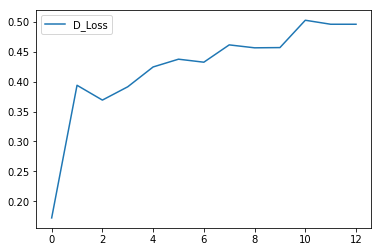

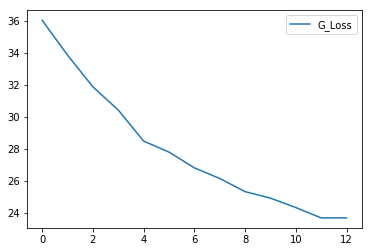

In [17]:
plt.plot(D_avg_losses,label="D_Loss")
plt.legend()
plt.show()
plt.plot(G_avg_losses,label="G_Loss")
plt.legend()
plt.show()

# Testing

In [14]:

PATH="saved_models/bestmodel.pth"
checkpoint = torch.load(PATH)
G.load_state_dict(checkpoint['g_state_dict'],strict=True)
D.load_state_dict(checkpoint['d_state_dict'],strict=True)

In [22]:



def plot_test_result2(input, target, gen_image,i, epoch, abs_file_name, w1,h1,
                     training=False, save=False, ex_dir='results/', show=False, fig_size=(10, 10)):
    abs_file_name=str(abs_file_name)[2:-3]
    print(abs_file_name)
    my_dpi = 96.0 # Good default - doesn't really matter
    #h = 576
    #w = 720
    print(w1,h1)
    #if not training:
    
        #fig_size = (input.size(2) * 6 / 100, input.size(3)*2/100)
        #fig_size = fig_size_tuple
    w=w1.item()
    h=h1.item()

    print("integers: ",w,h)

        

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
    ax.set_position([0, 0, 1, 1]) # Critical!
    #imgs = [gen_image]
    #for ax, img in zip(axes, imgs):
    ax.axis('off')
    #plt.set_adjustable('box-forced')
    # Scale to 0-255
    img = (((gen_image[0] - gen_image[0].min()) * 255) / (gen_image[0].max() - gen_image[0].min())).numpy().transpose(1, 2, 0).astype(np.uint8)
    #print("after img")
    ax.imshow(img, cmap=None, aspect='auto')
    #print("after imshow..")
    #plt.show()
        
#     for ax, color in zip(axes.flatten(), ['green', 'green', 'green']):
#         plt.setp(ax.spines.values(), color=color)
#         plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=color)
    
   # plt.subplots_adjust(wspace=0.05, hspace=0.05)


    if training:
        title = 'Epoch {0}'.format(epoch + 1)
        fig.text(0.5, 0.04, title, ha='center')

    # save figure
    if save:
        if not os.path.exists(ex_dir):
            os.makedirs(ex_dir)
        
        
        if training:
            save_fn = ex_dir + 'Result_epoch_{:d}'.format(epoch+1) + '.png'
        else:
            save_fn = ex_dir + abs_file_name
            print(save_fn)
            #fig.subplots_adjust(bottom=0)
            #fig.subplots_adjust(top=1)
            #fig.subplots_adjust(right=1)
            #fig.subplots_adjust(left=0)
        fig.savefig(save_fn)
        size_ss = fig.get_size_inches()*fig.dpi # size in pixels

        print("Figure Size in inches:",fig.get_size_inches(),", DPI:",fig.dpi,"SIZE in Pix:",size_ss)
        
    if show:
        plt.show()
    else:
        plt.close()




In [67]:


# from matplotlib.transforms import Bbox





# def plot_test_result2(input, target, gen_image,i, epoch, abs_file_name, fig_size_tuple,
#                      training=False, save=False, ex_dir='results/', show=False, fig_size=(10, 10)):
#     abs_file_name=str(abs_file_name)[2:-3]
#     print(abs_file_name)
    
#     #if not training:
    
#         #fig_size = (input.size(2) * 6 / 100, input.size(3)*2/100)
#         #fig_size = fig_size_tuple
        
#     plt.figure(figsize=(10.841, 7.195), dpi=100)
#     #plt.savefig('myfig.png', dpi=1000)

#     #fig = plt.figure(figsize=fig_size_tuple)
#     #imgs = [gen_image]
#     #for ax, img in zip(axes, imgs):
#     plt.axis('off')
#     #plt.set_adjustable('box-forced')
#     # Scale to 0-255
#     img = (((gen_image[0] - gen_image[0].min()) * 255) / (gen_image[0].max() - gen_image[0].min())).numpy().transpose(1, 2, 0).astype(np.uint8)
#     #print("after img")
#     plt.imshow(img, cmap=None, aspect='equal')
#     #print("after imshow..")
#     #plt.show()
        
# #     for ax, color in zip(axes.flatten(), ['green', 'green', 'green']):
# #         plt.setp(ax.spines.values(), color=color)
# #         plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=color)
    
#    # plt.subplots_adjust(wspace=0.05, hspace=0.05)


#     if training:
#         title = 'Epoch {0}'.format(epoch + 1)
#         fig.text(0.5, 0.04, title, ha='center')

#     # save figure
#     if save:
#         if not os.path.exists(ex_dir):
#             os.makedirs(ex_dir)
        
        
#         if training:
#             save_fn = ex_dir + 'Result_epoch_{:d}'.format(epoch+1) + '.png'
#         else:
#             save_fn = ex_dir + abs_file_name
#             print(save_fn)
#             #fig.subplots_adjust(bottom=0)
#             #fig.subplots_adjust(top=1)
#             #fig.subplots_adjust(right=1)
#             #fig.subplots_adjust(left=0)
#         plt.savefig(save_fn, dpi = 100)
        
#     if show:
#         plt.show()
#     else:
#         plt.close()

In [24]:
transform = transforms.Compose([transforms.Resize(input_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])


test_data = DatasetFromFolderTest(data_dir, subfolder='test/', transform=transform,
                               resize_scale=resize_scale, crop_size=crop_size, fliplr=fliplr)

test_data_loader = torch.utils.data.DataLoader(dataset=test_data,
                                               batch_size=1,
                                               shuffle=False)



for i, (test_input, test_target, abs_file_name,im_width,im_height) in enumerate(test_data_loader):
    
    print(abs_file_name, im_width, im_height)
    # input & target image data
    x_test = Variable(test_input.cuda())
    y_test = Variable(test_target.cuda())

    # Train discriminator with fake data
    gen_image = G(x_test)
    gen_image = gen_image.cpu().data
    print("Image number:",i)
    plot_test_result2(test_input, test_target, gen_image,i, epoch=0,
                      abs_file_name=abs_file_name,w1=im_width,h1=im_height,  save=True, ex_dir=ex_dir+"test_results/")






('ckcai75gy0rwm0y47f6zm6c4y.jpg',) tensor([720]) tensor([576])
Image number: 0
ckcai75gy0rwm0y47f6zm6c4y.jpg
tensor([720]) tensor([576])
integers:  720 576
seg_results/99/test_results/ckcai75gy0rwm0y47f6zm6c4y.jpg
Figure Size in inches: [7.5 6. ] , DPI: 96.0 SIZE in Pix: [720. 576.]
('ckcai9nma2xig0y6g595c7mtj.jpg',) tensor([720]) tensor([576])
Image number: 1
ckcai9nma2xig0y6g595c7mtj.jpg
tensor([720]) tensor([576])
integers:  720 576
seg_results/99/test_results/ckcai9nma2xig0y6g595c7mtj.jpg
Figure Size in inches: [7.5 6. ] , DPI: 96.0 SIZE in Pix: [720. 576.]
('ckcaibt572pxu0y6fazrxcc4f.jpg',) tensor([720]) tensor([576])
Image number: 2
ckcaibt572pxu0y6fazrxcc4f.jpg
tensor([720]) tensor([576])
integers:  720 576
seg_results/99/test_results/ckcaibt572pxu0y6fazrxcc4f.jpg
Figure Size in inches: [7.5 6. ] , DPI: 96.0 SIZE in Pix: [720. 576.]
('ckcaidxum2xrf0y6g0329hw80.jpg',) tensor([768]) tensor([576])
Image number: 3
ckcaidxum2xrf0y6g0329hw80.jpg
tensor([768]) tensor([576])
integers:  

('ckcbpz4vz28i70y5p347j9b4a.jpg',) tensor([720]) tensor([576])
Image number: 29
ckcbpz4vz28i70y5p347j9b4a.jpg
tensor([720]) tensor([576])
integers:  720 576
seg_results/99/test_results/ckcbpz4vz28i70y5p347j9b4a.jpg
Figure Size in inches: [7.5 6. ] , DPI: 96.0 SIZE in Pix: [720. 576.]
('ckcbq0gs703hv0y4h735ha581.jpg',) tensor([720]) tensor([576])
Image number: 30
ckcbq0gs703hv0y4h735ha581.jpg
tensor([720]) tensor([576])
integers:  720 576
seg_results/99/test_results/ckcbq0gs703hv0y4h735ha581.jpg
Figure Size in inches: [7.5 6. ] , DPI: 96.0 SIZE in Pix: [720. 576.]
('ckcbq2a7722d90y6g4h9rd9gw.jpg',) tensor([720]) tensor([576])
Image number: 31
ckcbq2a7722d90y6g4h9rd9gw.jpg
tensor([720]) tensor([576])
integers:  720 576
seg_results/99/test_results/ckcbq2a7722d90y6g4h9rd9gw.jpg
Figure Size in inches: [7.5 6. ] , DPI: 96.0 SIZE in Pix: [720. 576.]
('ckcbq43s523fe0y5n126g6w5h.jpg',) tensor([720]) tensor([576])
Image number: 32
ckcbq43s523fe0y5n126g6w5h.jpg
tensor([720]) tensor([576])
integer

Figure Size in inches: [7.5 6. ] , DPI: 96.0 SIZE in Pix: [720. 576.]
('ckd8srbmv00013b5sliek3ejo.jpg',) tensor([768]) tensor([576])
Image number: 58
ckd8srbmv00013b5sliek3ejo.jpg
tensor([768]) tensor([576])
integers:  768 576
seg_results/99/test_results/ckd8srbmv00013b5sliek3ejo.jpg
Figure Size in inches: [8. 6.] , DPI: 96.0 SIZE in Pix: [768. 576.]
('ckd8srxq500023b5ssndncx7o.jpg',) tensor([768]) tensor([576])
Image number: 59
ckd8srxq500023b5ssndncx7o.jpg
tensor([768]) tensor([576])
integers:  768 576
seg_results/99/test_results/ckd8srxq500023b5ssndncx7o.jpg
Figure Size in inches: [8. 6.] , DPI: 96.0 SIZE in Pix: [768. 576.]
('ckd8ssoan00033b5sdjgxl66l.jpg',) tensor([720]) tensor([576])
Image number: 60
ckd8ssoan00033b5sdjgxl66l.jpg
tensor([720]) tensor([576])
integers:  720 576
seg_results/99/test_results/ckd8ssoan00033b5sdjgxl66l.jpg
Figure Size in inches: [7.5 6. ] , DPI: 96.0 SIZE in Pix: [720. 576.]
('ckd8stdnx00043b5sxun8ewkv.jpg',) tensor([720]) tensor([576])
Image number: 61

seg_results/99/test_results/ckd8u03ax000b3b5s6wlo2oa1.jpg
Figure Size in inches: [8. 6.] , DPI: 96.0 SIZE in Pix: [768. 576.]
('ckd8u18d7000c3b5suod5aqf2.jpg',) tensor([720]) tensor([576])
Image number: 87
ckd8u18d7000c3b5suod5aqf2.jpg
tensor([720]) tensor([576])
integers:  720 576
seg_results/99/test_results/ckd8u18d7000c3b5suod5aqf2.jpg
Figure Size in inches: [7.5 6. ] , DPI: 96.0 SIZE in Pix: [720. 576.]
('ckd8u26a5000d3b5sa5f1vgiz.jpg',) tensor([720]) tensor([576])
Image number: 88
ckd8u26a5000d3b5sa5f1vgiz.jpg
tensor([720]) tensor([576])
integers:  720 576
seg_results/99/test_results/ckd8u26a5000d3b5sa5f1vgiz.jpg
Figure Size in inches: [7.5 6. ] , DPI: 96.0 SIZE in Pix: [720. 576.]
('ckd8u31cm000e3b5s3mbgboro.jpg',) tensor([720]) tensor([576])
Image number: 89
ckd8u31cm000e3b5s3mbgboro.jpg
tensor([720]) tensor([576])
integers:  720 576
seg_results/99/test_results/ckd8u31cm000e3b5s3mbgboro.jpg
Figure Size in inches: [7.5 6. ] , DPI: 96.0 SIZE in Pix: [720. 576.]
('ckd8u3pst000f3b5s

('ckda1j0sy000n3a5stotfjqpc.jpg',) tensor([720]) tensor([576])
Image number: 115
ckda1j0sy000n3a5stotfjqpc.jpg
tensor([720]) tensor([576])
integers:  720 576
seg_results/99/test_results/ckda1j0sy000n3a5stotfjqpc.jpg
Figure Size in inches: [7.5 6. ] , DPI: 96.0 SIZE in Pix: [720. 576.]
('ckda1jqsp000o3a5s5lh3pkdn.jpg',) tensor([720]) tensor([576])
Image number: 116
ckda1jqsp000o3a5s5lh3pkdn.jpg
tensor([720]) tensor([576])
integers:  720 576
seg_results/99/test_results/ckda1jqsp000o3a5s5lh3pkdn.jpg
Figure Size in inches: [7.5 6. ] , DPI: 96.0 SIZE in Pix: [720. 576.]
('ckda1spnc000q3a5srfxlvwce.jpg',) tensor([768]) tensor([576])
Image number: 117
ckda1spnc000q3a5srfxlvwce.jpg
tensor([768]) tensor([576])
integers:  768 576
seg_results/99/test_results/ckda1spnc000q3a5srfxlvwce.jpg
Figure Size in inches: [8. 6.] , DPI: 96.0 SIZE in Pix: [768. 576.]
('ckda1tdd8000r3a5sx5xvm4kv.jpg',) tensor([720]) tensor([576])
Image number: 118
ckda1tdd8000r3a5sx5xvm4kv.jpg
tensor([720]) tensor([576])
integ

Figure Size in inches: [8. 6.] , DPI: 96.0 SIZE in Pix: [768. 576.]
('ckda5wgcv000d3a5s3804l420.jpg',) tensor([1280]) tensor([1024])
Image number: 144
ckda5wgcv000d3a5s3804l420.jpg
tensor([1280]) tensor([1024])
integers:  1280 1024
seg_results/99/test_results/ckda5wgcv000d3a5s3804l420.jpg
Figure Size in inches: [13.33333333 10.66666667] , DPI: 96.0 SIZE in Pix: [1280. 1024.]
('ckda5wz53000e3a5s4v8to66t.jpg',) tensor([768]) tensor([576])
Image number: 145
ckda5wz53000e3a5s4v8to66t.jpg
tensor([768]) tensor([576])
integers:  768 576
seg_results/99/test_results/ckda5wz53000e3a5s4v8to66t.jpg
Figure Size in inches: [8. 6.] , DPI: 96.0 SIZE in Pix: [768. 576.]
('ckda5xk19000f3a5s6rpp4xlq.jpg',) tensor([768]) tensor([576])
Image number: 146
ckda5xk19000f3a5s6rpp4xlq.jpg
tensor([768]) tensor([576])
integers:  768 576
seg_results/99/test_results/ckda5xk19000f3a5s6rpp4xlq.jpg
Figure Size in inches: [8. 6.] , DPI: 96.0 SIZE in Pix: [768. 576.]
('ckda5xyr4000g3a5sc1dpzwya.jpg',) tensor([720]) tenso

In [33]:
test_input

tensor([[[[-0.9686, -0.9608, -0.9686,  ..., -0.9686, -0.9686, -0.9608],
          [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
          [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9765],
          ...,
          [-0.9922, -1.0000, -1.0000,  ..., -1.0000, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -1.0000, -1.0000, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922]],

         [[-0.9686, -0.9608, -0.9686,  ..., -0.9686, -0.9686, -0.9608],
          [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
          [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9765],
          ...,
          [-0.9922, -1.0000, -1.0000,  ..., -1.0000, -0.9922, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -1.0000, -1.0000, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922]],

         [[-0.9686, -0.9686, -0.9843,  ..., -0.9686, -0.9686, -0.9608],
          [-0.9686, -0.9765, -

In [32]:
abs_file_name

('ckcai75gy0rwm0y47f6zm6c4y.jpg',)

In [17]:
x_test.shape

torch.Size([1, 3, 256, 256])

In [18]:
transforms.Resize(input_size)

Resize(size=256, interpolation=PIL.Image.BILINEAR)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


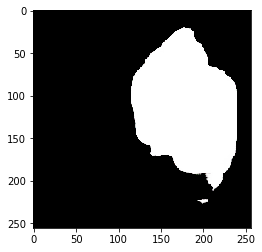

In [19]:
plt.imshow(gen_image[0,:,:,:].permute(1, 2, 0))



In [27]:
def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    # print(img.size)
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)


In [43]:
gen_image.shape

torch.Size([3, 256, 256])

In [18]:
ss=transforms.ToPILImage()(gen_image.squeeze_(0))

In [18]:
transform_forshape = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])


test_data_forshape = DatasetFromFolder(data_dir, subfolder='test/', transform=transform_forshape,
                                crop_size=crop_size, fliplr=fliplr)



test_data_loader_forshape = torch.utils.data.DataLoader(dataset=test_data_forshape,
                                               batch_size=1,
                                               shuffle=False)


In [19]:
transform = transforms.Compose([transforms.Resize(input_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

test_data = DatasetFromFolder(data_dir, subfolder='test/', transform=transform,
                               resize_scale=resize_scale, crop_size=crop_size, fliplr=fliplr)

test_data_loader = torch.utils.data.DataLoader(dataset=test_data,
                                               batch_size=1,
                                               shuffle=False)


In [18]:
len(test_data_loader)

160

In [19]:
shapes=np.zeros((len(test_data_loader),2), dtype=int)
for i, (test_input0, test_target0) in enumerate(test_data_loader_forshape):
        shapes[i,0]= test_input0.shape[2]
        shapes[i,1]= test_input0.shape[3]
        print(i,shapes[i,:])

    


0 [576 720]
1 [576 720]
2 [576 720]
3 [576 768]
4 [576 720]
5 [576 720]
6 [576 720]
7 [576 720]
8 [576 720]
9 [576 720]
10 [576 720]
11 [576 720]
12 [576 720]
13 [576 720]
14 [576 720]
15 [576 720]
16 [576 720]
17 [576 720]
18 [576 720]
19 [576 768]
20 [576 720]
21 [576 720]
22 [576 720]
23 [576 768]
24 [576 720]
25 [576 720]
26 [576 768]
27 [576 768]
28 [576 720]
29 [576 720]
30 [576 720]
31 [576 720]
32 [576 720]
33 [576 720]
34 [576 720]
35 [576 720]
36 [576 768]
37 [576 720]
38 [576 720]
39 [576 720]
40 [576 720]
41 [576 720]
42 [576 720]
43 [576 720]
44 [576 720]
45 [576 768]
46 [576 768]
47 [576 720]
48 [576 720]
49 [576 768]
50 [576 720]
51 [576 720]
52 [576 720]
53 [576 720]
54 [1072 1920]
55 [576 720]
56 [576 768]
57 [576 720]
58 [576 768]
59 [576 768]
60 [576 720]
61 [576 720]
62 [576 720]
63 [576 720]
64 [576 720]
65 [576 720]
66 [576 768]
67 [576 768]
68 [576 720]
69 [576 768]
70 [576 768]
71 [576 768]
72 [576 720]
73 [576 768]
74 [576 720]
75 [576 720]
76 [576 768]
77 [102

In [20]:
shapes

array([[ 576,  720],
       [ 576,  720],
       [ 576,  720],
       [ 576,  768],
       [ 576,  720],
       [ 576,  720],
       [ 576,  720],
       [ 576,  720],
       [ 576,  720],
       [ 576,  720],
       [ 576,  720],
       [ 576,  720],
       [ 576,  720],
       [ 576,  720],
       [ 576,  720],
       [ 576,  720],
       [ 576,  720],
       [ 576,  720],
       [ 576,  720],
       [ 576,  768],
       [ 576,  720],
       [ 576,  720],
       [ 576,  720],
       [ 576,  768],
       [ 576,  720],
       [ 576,  720],
       [ 576,  768],
       [ 576,  768],
       [ 576,  720],
       [ 576,  720],
       [ 576,  720],
       [ 576,  720],
       [ 576,  720],
       [ 576,  720],
       [ 576,  720],
       [ 576,  720],
       [ 576,  768],
       [ 576,  720],
       [ 576,  720],
       [ 576,  720],
       [ 576,  720],
       [ 576,  720],
       [ 576,  720],
       [ 576,  720],
       [ 576,  720],
       [ 576,  768],
       [ 576,  768],
       [ 576,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

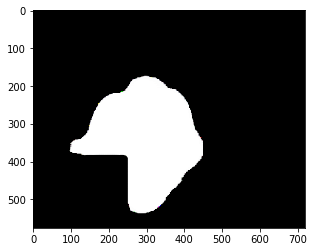

In [33]:

for i, (test_input, test_target,file_name) in enumerate(test_data_loader):
    print(file_name)
    
    # input & target image data
    x_test = Variable(test_input.cuda())
    y_test = Variable(test_target.cuda())
    

    # Train discriminator with fake data
    gen_image = G(x_test)
    gen_image = gen_image.cpu().data

    
    test_inputshp, test_targetshp = test_data_loader_forshape.__iter__().__next__()
    #test_inputshp, test_targetshp = next(iter(test_data_loader_forshape))
    original_size= test_inputshp.shape
    
    
    gen_image_IMG=transforms.ToPILImage()(gen_image.squeeze_(0))
    
    transform_to_original_mask = transforms.Compose([transforms.Resize((shapes[i,0],shapes[i,1])),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
    
    
    transform_to_original_img = transforms.Compose([transforms.Resize((shapes[i,0],shapes[i,1])),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
    
    
    
    msk_to_original=transform_to_original(gen_image_IMG)
    plt.imshow(msk_to_original.permute(1, 2, 0))
    #plt.show()
    
#     plt.imshow(test_inputshp[0,:,:,:].cpu().data.permute(1, 2, 0)) 
#     plt.show() 
    
#     test_input11=transforms.ToPILImage()(test_input.squeeze_(0))
#     img_to_original=transform_to_original_img(test_input11)
#     plt.imshow(img_to_original.permute(1, 2, 0)) 
#     plt.show()
    fn='test_results/'+str(i)
    plt.savefig(fn)
    

    #plot_test_result(test_input, test_target, gen_image, i, save=True, ex_dir=ex_dir+"test_results/")



In [42]:
img_to_original.shape

torch.Size([3, 576, 720])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


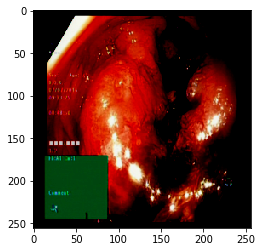

In [75]:
for i, (test_input, test_target) in enumerate(test_data_loader):
    
    
    print(test_input.shape)
#     plt.imshow(test_input[0,:,:,:].permute(1, 2, 0))
#     plt.show()

    

torch.Size([1, 3, 576, 720])
torch.Size([1, 3, 576, 720])
torch.Size([1, 3, 576, 720])
torch.Size([1, 3, 576, 768])
torch.Size([1, 3, 576, 720])
torch.Size([1, 3, 576, 720])
torch.Size([1, 3, 576, 720])
torch.Size([1, 3, 576, 720])
torch.Size([1, 3, 576, 720])
torch.Size([1, 3, 576, 720])
torch.Size([1, 3, 576, 720])
torch.Size([1, 3, 576, 720])
torch.Size([1, 3, 576, 720])
torch.Size([1, 3, 576, 720])
torch.Size([1, 3, 576, 720])
torch.Size([1, 3, 576, 720])
torch.Size([1, 3, 576, 720])
torch.Size([1, 3, 576, 720])
torch.Size([1, 3, 576, 720])
torch.Size([1, 3, 576, 768])
torch.Size([1, 3, 576, 720])
torch.Size([1, 3, 576, 720])
torch.Size([1, 3, 576, 720])
torch.Size([1, 3, 576, 768])
torch.Size([1, 3, 576, 720])
torch.Size([1, 3, 576, 720])
torch.Size([1, 3, 576, 768])
torch.Size([1, 3, 576, 768])
torch.Size([1, 3, 576, 720])
torch.Size([1, 3, 576, 720])
torch.Size([1, 3, 576, 720])
torch.Size([1, 3, 576, 720])
torch.Size([1, 3, 576, 720])
torch.Size([1, 3, 576, 720])
torch.Size([1,

In [39]:
ss2=transform2(ss)#.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


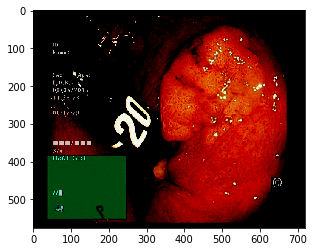

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


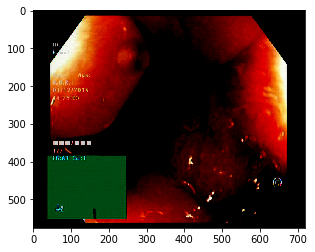

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


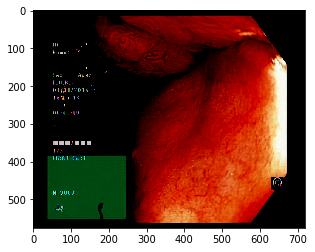

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


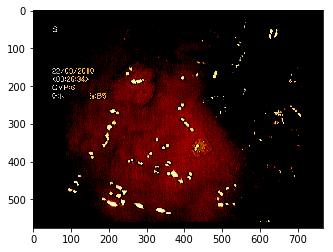

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


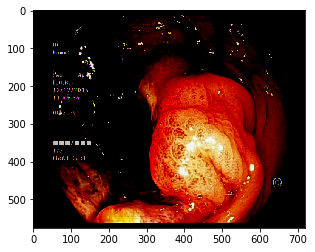

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


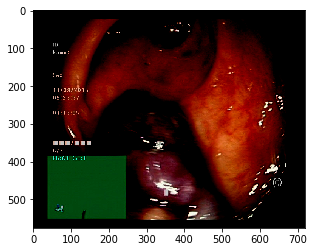

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


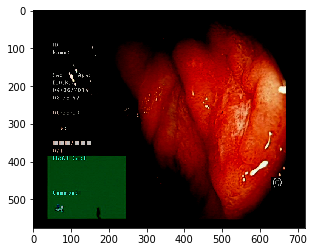

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


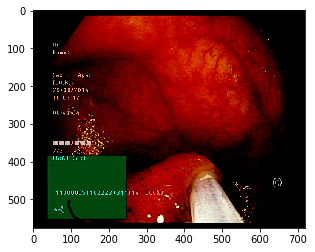

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


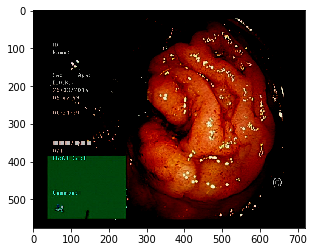

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


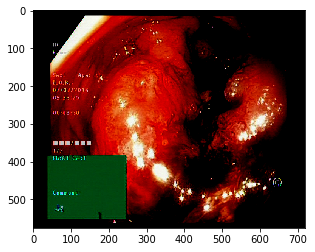

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


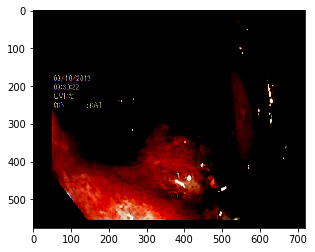

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


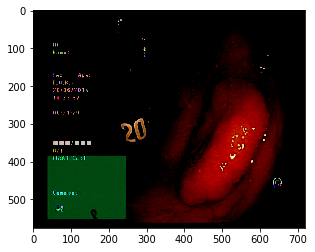

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


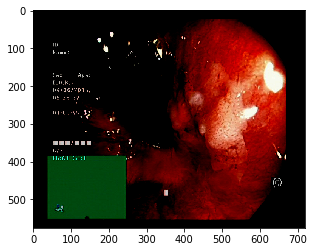

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


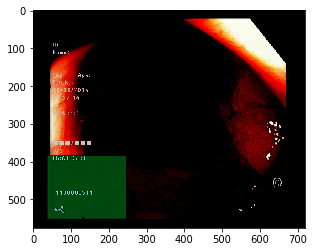

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


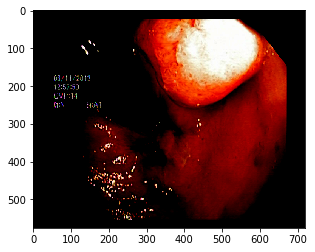

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


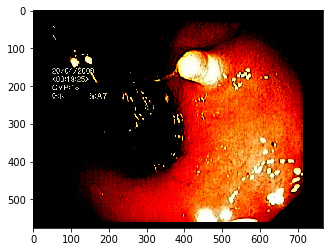

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


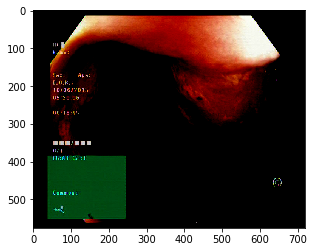

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


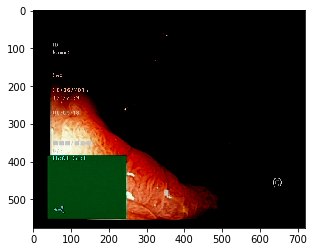

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


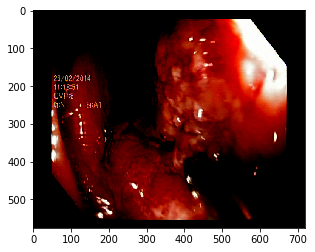

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


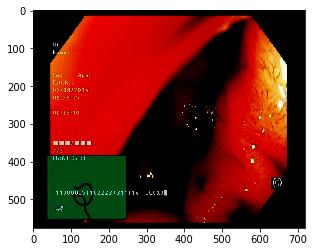

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


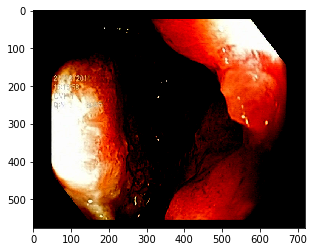

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


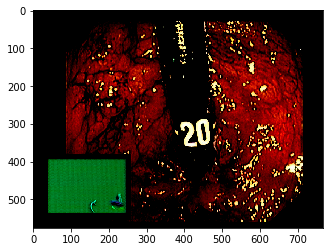

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


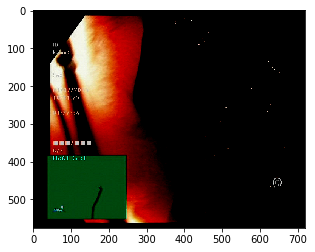

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


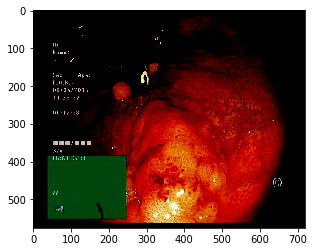

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


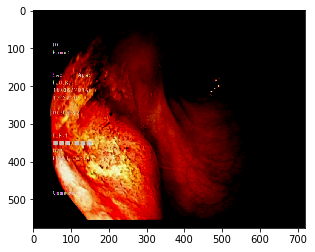

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


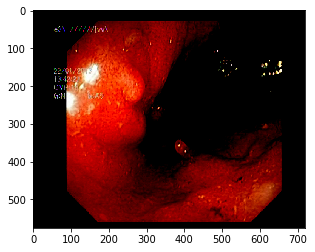

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


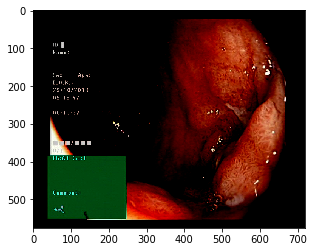

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


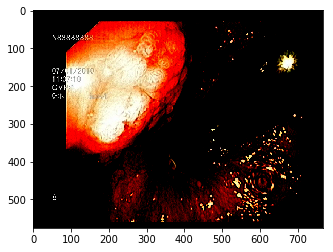

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


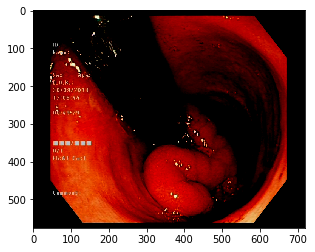

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


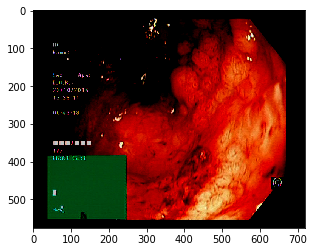

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


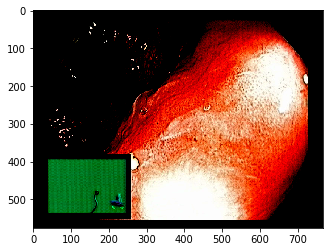

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


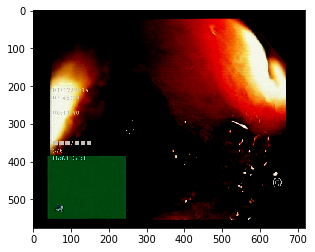

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


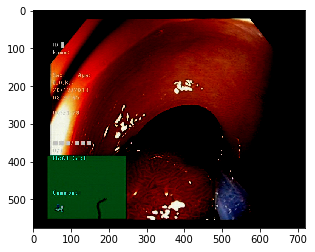

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


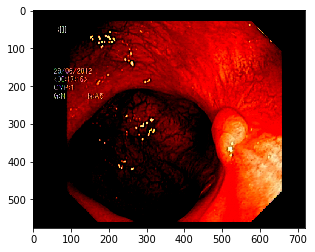

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


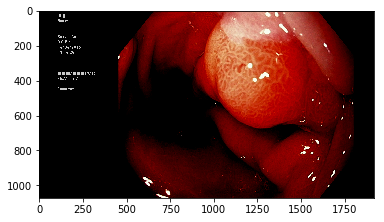

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


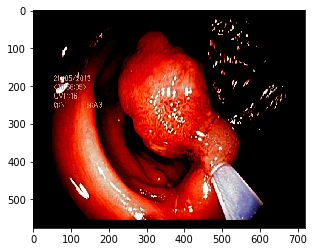

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


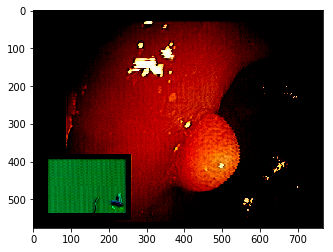

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


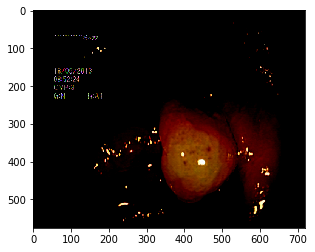

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


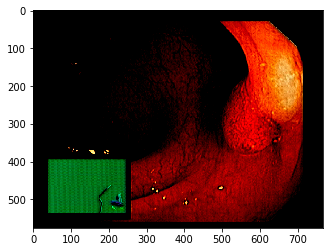

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KeyboardInterrupt: 

In [29]:
for i, (test_input11, test_target11) in enumerate(test_data_loader_forshape):
    #test_inputshp, test_targetshp = test_data_loader_forshape.__iter__().__next__()
    plt.imshow(test_input11[0,:,:,:].cpu().data.permute(1, 2, 0)) 
    plt.show() 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


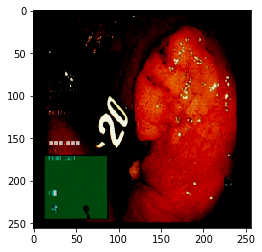

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


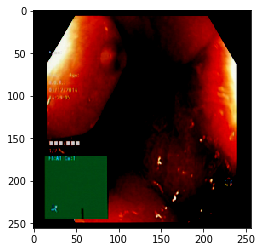

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


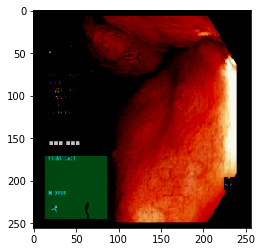

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


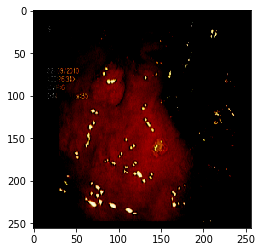

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


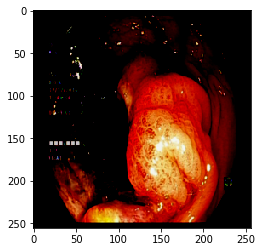

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


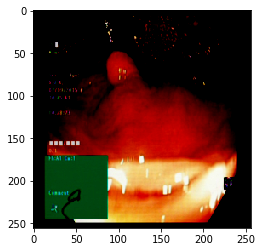

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


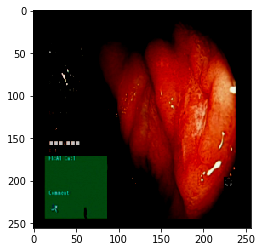

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KeyboardInterrupt: 

In [30]:
for i, (test_input22, test_target22) in enumerate(test_data_loader ):
    #test_inputshp, test_targetshp = test_data_loader_forshape.__iter__().__next__()
    plt.imshow(test_input22[0,:,:,:].cpu().data.permute(1, 2, 0)) 
    plt.show() 


In [22]:
plt.imshow(ss2.permute(1, 2, 0))
plt.imshow(test_inputshp[0,:,:,:].cpu().data.permute(1, 2, 0)) 
plt.show() 

NameError: name 'ss2' is not defined